## Предисловие ##
В коде сначала обучается variational autoencoder, чтобы затем использовать часть с декодером для генерации изображений в обучении с дискриминатором.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, BatchNormalization, Dropout, Rescaling, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU
import zipfile

## Подготовка изображений ##


In [ ]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print(x_train.shape)

(60000, 28, 28)


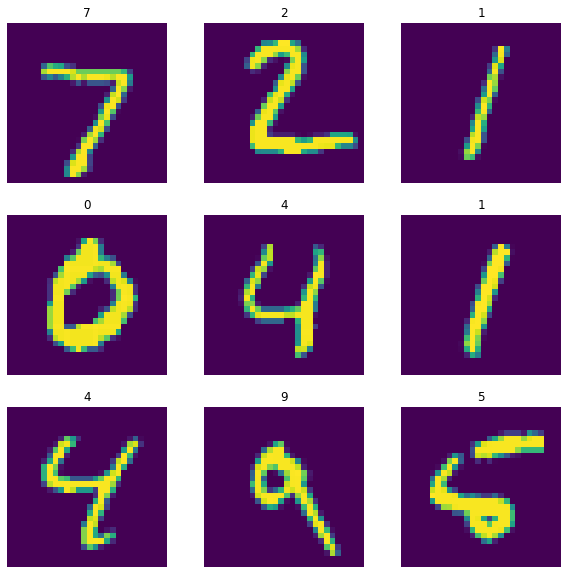

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x_test[i].reshape(28, 28)*255)
    plt.title(y_test[i])
    plt.axis("off")

In [ ]:
img_size = x_train.shape[1]
batch_size = 1000

# делаем категориальное представление
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
num_classes = y_test.shape[1]

x_train = x_train[:10000]

img_size

28

## Модель 1. Variational autoencoder. ##

In [ ]:
hidden_dim = 16

def dropout_and_batch(x):
  return Dropout(0.3)(BatchNormalization()(x))

input_enc = Input((img_size, img_size))
x = Flatten()(input_enc)
x = Dense(64, activation='relu')(x)
x = dropout_and_batch(x)
x = Dense(32, activation='relu')(x)
x = dropout_and_batch(x)

h_mean = Dense(hidden_dim)(x)
log_hstd = Dense(hidden_dim)(x)

def make_hidden_state(harr):
    global h_mean, log_hstd
    h_mean, log_hstd = harr
    N = K.random_normal(shape=(hidden_dim,), mean=0., stddev=1.0)
    return K.exp(log_hstd / 2) * N + h_mean

hidden_state = Lambda(make_hidden_state, 
                      output_shape=(hidden_dim,))([h_mean, log_hstd])

size4 = img_size // 4
input_dec = Input(shape=(hidden_dim,))
d = Dense(size4*size4*64, activation='relu')(input_dec)
d = BatchNormalization()(d)
d = Reshape((size4, size4, 64))(d)
d = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(d)
d = BatchNormalization()(d)
d = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', activation='relu')(d)
d = BatchNormalization()(d)
decoded = Conv2DTranspose(1, (3, 3), padding='same', activation='sigmoid')(d)

encoder = keras.Model(input_enc, hidden_state, name='encoder')
decoder = keras.Model(input_dec, decoded, name='decoder')

In [ ]:
def vae_loss(x, y):
    x = K.reshape(x, shape=(batch_size, img_size*img_size*1))
    y = K.reshape(y, shape=(batch_size, img_size*img_size*1))
    # отклонение сгенерированной картинки от настоящей
    loss = K.sum(K.square(x-y), axis=-1)
    # дивергенция Кульбака-Лейблера
    kl_loss = -0.5 * K.sum(1 + log_hstd - K.square(h_mean) - K.exp(log_hstd), axis=-1)
    return loss + kl_loss

vae = keras.Model(input_enc, decoder(encoder(input_enc)), name="vae")
vae.optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
vae.compile(loss=vae_loss)

num_epochs = 50
vae.fit(x_train, x_train,
        epochs=num_epochs, 
        batch_size=batch_size, 
        shuffle=True)


Epoch 1/50
10/10 [==============================] - 13s 1s/step - loss: 202.6754
Epoch 2/50
10/10 [==============================] - 12s 1s/step - loss: 139.7473
Epoch 3/50
10/10 [==============================] - 11s 1s/step - loss: 108.3502
Epoch 4/50
10/10 [==============================] - 11s 1s/step - loss: 90.4980
Epoch 5/50
10/10 [==============================] - 11s 1s/step - loss: 77.4294
Epoch 6/50
10/10 [==============================] - 11s 1s/step - loss: 68.0782
Epoch 7/50
10/10 [==============================] - 11s 1s/step - loss: 62.0153
Epoch 8/50
10/10 [==============================] - 11s 1s/step - loss: 58.1434
Epoch 9/50
10/10 [==============================] - 11s 1s/step - loss: 53.1720
Epoch 10/50
10/10 [==============================] - 11s 1s/step - loss: 51.2589
Epoch 11/50
10/10 [==============================] - 11s 1s/step - loss: 49.4227
Epoch 12/50
10/10 [==============================] - 11s 1s/step - loss: 47.2566
Epoch 13/50
10/10 [===============

Отображение полученных результатов:

1/1 [==============================] - 0s 19ms/step


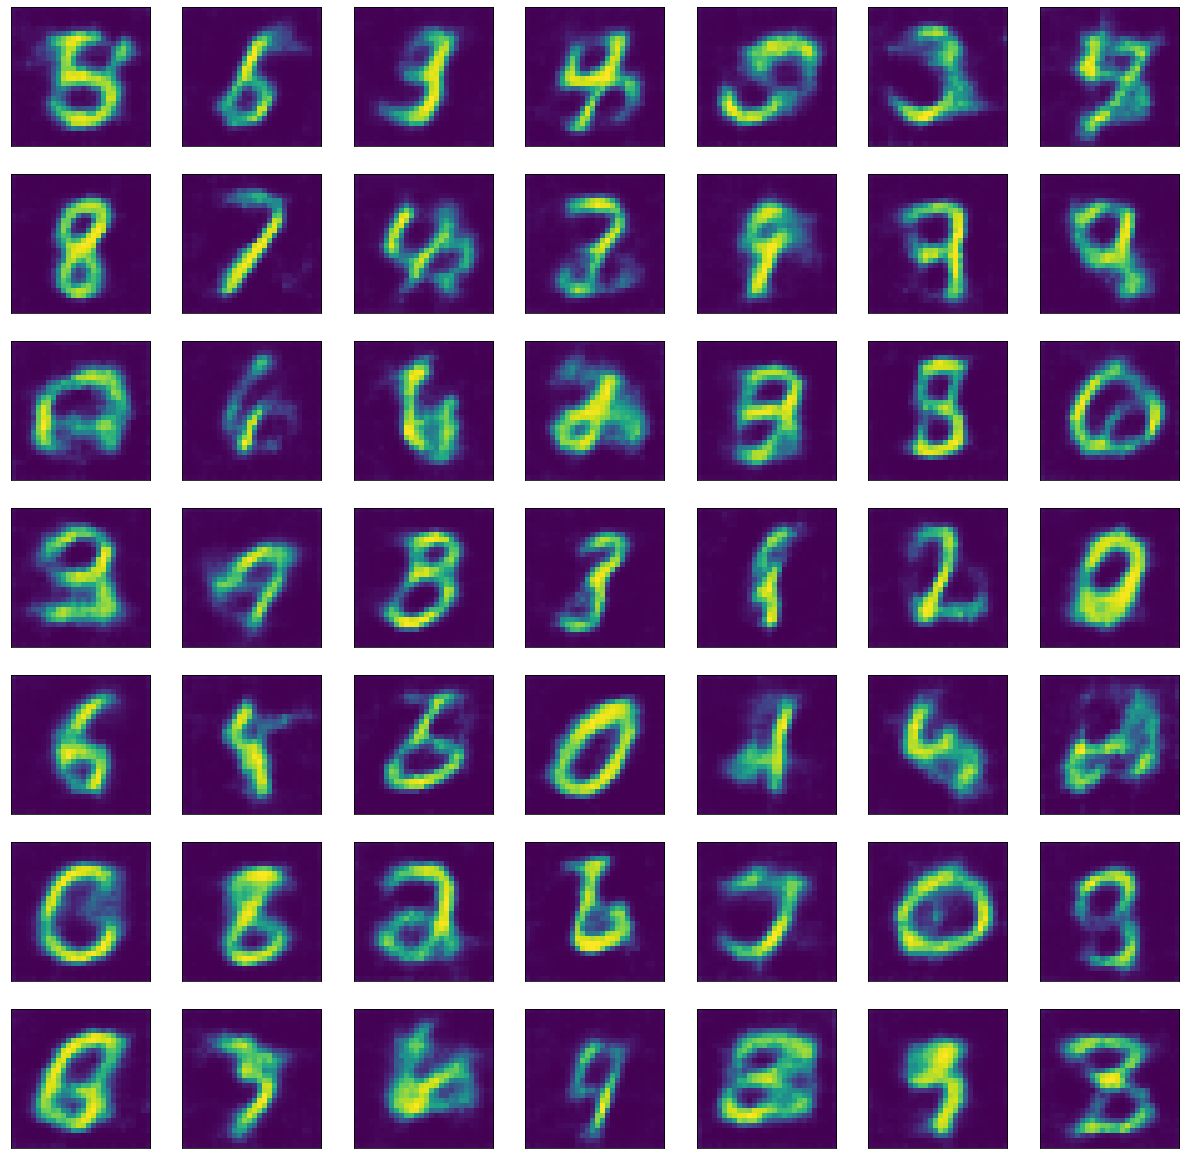

In [ ]:
n = 3
total = 2*n+1

plt.figure(figsize=(3*total, 3*total))

num = 1
for i in range(-n, n+1):
  for j in range(-n, n+1):
    ax = plt.subplot(total, total, num)
    num += 1
    h0 = 0.8*tf.random.normal([1, hidden_dim])
    # img = np.array(decoder.predict(h0) * 255, dtype=int)
    img = np.array(decoder.predict(h0))
    plt.imshow(img.squeeze())
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# decoder.save('/content/drive/MyDrive/dec1')

In [ ]:
decoder.save('/content/drive/MyDrive/decoder.h5')

## Модель 2. generator+discriminator. ##

In [163]:
decoder = tf.keras.models.load_model("/content/drive/MyDrive/decoder.h5")

discriminator = tf.keras.Sequential()

discriminator.add(Conv2D(32, (3, 3), strides=(2, 2), padding='same', input_shape=(img_size, img_size, 1)))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(alpha=0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1))


In [164]:
class CustomGAN(keras.Model):
    def __init__(self, discriminator, generator):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.g_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.d_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    def compile(self, g_optimizer, d_optimizer, loss_func):
        super().compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.loss_fn = loss_func

    def train_step(self, dataset):
        real_images, y = dataset
        real_images = tf.reshape(real_images, [batch_size, img_size, img_size, 1])
        noise = tf.random.normal([batch_size, hidden_dim])
        fake_images = self.generator(noise)
        combined_images = tf.concat([real_images, fake_images], axis=0)
        labels = tf.concat(
                [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)

        # Update discriminator weights
        with tf.GradientTape() as tape:
            pred = self.discriminator(combined_images, training=True)
            d_loss = self.loss_fn(labels, pred)

        d_grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        # Update generator weights
        noise = tf.random.normal([batch_size, hidden_dim])

        with tf.GradientTape() as tape:
            fake_images = self.generator(noise, training=True)
            pred = self.discriminator(fake_images)
            g_loss = self.loss_fn(tf.ones((batch_size, 1)), pred)

        g_grads = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        # Monitor loss
        self.g_loss_tracker.update_state(g_loss)
        self.d_loss_tracker.update_state(d_loss)
        return {"g_loss": self.g_loss_tracker.result(), 
                "d_loss": self.d_loss_tracker.result()}

    @property
    def metrics(self):
        return [self.g_loss_tracker, self.d_loss_tracker]

In [168]:
GAN = CustomGAN(discriminator=discriminator, generator=decoder)
GAN.compile(g_optimizer=tf.keras.optimizers.Adam(1e-5),
            d_optimizer=tf.keras.optimizers.Adam(1e-5), 
            loss_func=tf.keras.losses.BinaryCrossentropy(from_logits=True))

# запуск процесса обучения
EPOCHS = 10
batch_size = 1000

GAN.fit(x_train, x_train,
        epochs=EPOCHS, 
        batch_size=batch_size, 
        shuffle=True)

Epoch 1/10
10/10 [==============================] - 22s 2s/step - g_loss: 0.6812 - d_loss: 0.6943
Epoch 2/10
10/10 [==============================] - 19s 2s/step - g_loss: 0.6814 - d_loss: 0.6945
Epoch 3/10
10/10 [==============================] - 19s 2s/step - g_loss: 0.6809 - d_loss: 0.6946
Epoch 4/10
10/10 [==============================] - 20s 2s/step - g_loss: 0.6813 - d_loss: 0.6945
Epoch 5/10
10/10 [==============================] - 19s 2s/step - g_loss: 0.6807 - d_loss: 0.6953
Epoch 6/10
10/10 [==============================] - 21s 2s/step - g_loss: 0.6806 - d_loss: 0.6948
Epoch 7/10
10/10 [==============================] - 20s 2s/step - g_loss: 0.6803 - d_loss: 0.6948
Epoch 8/10
10/10 [==============================] - 19s 2s/step - g_loss: 0.6799 - d_loss: 0.6953
Epoch 9/10
10/10 [==============================] - 20s 2s/step - g_loss: 0.6797 - d_loss: 0.6952
Epoch 10/10
10/10 [==============================] - 19s 2s/step - g_loss: 0.6795 - d_loss: 0.6953


Отображение полученных результатов:

1/1 [==============================] - 0s 17ms/step


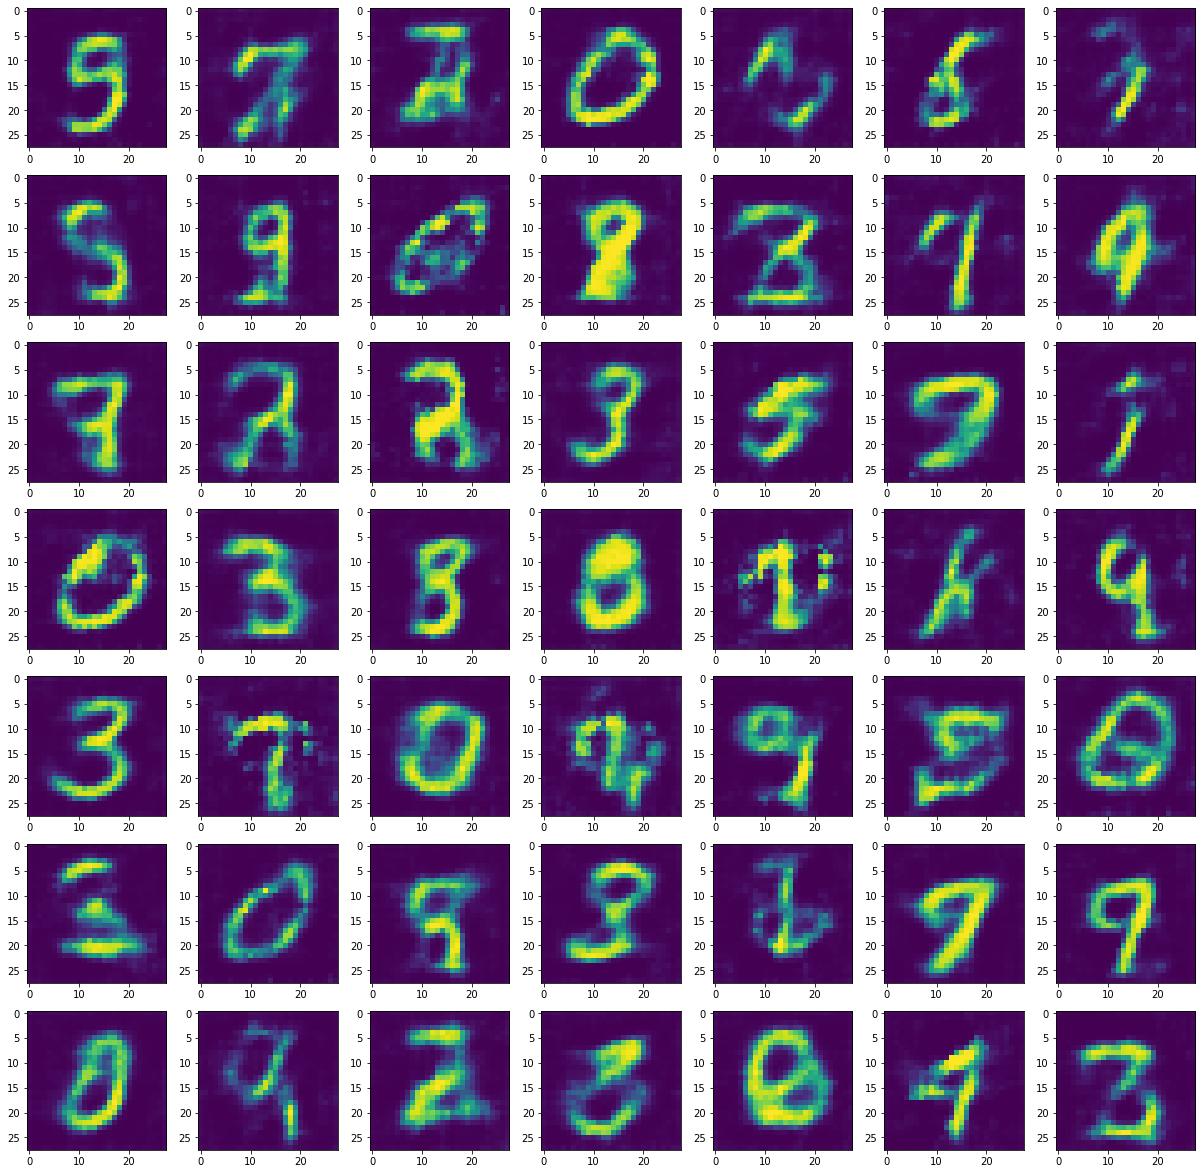

In [169]:
# decoder.save('/content/drive/MyDrive/gen2')
# discriminator.save('/content/drive/MyDrive/disc2')

n = 3
total = 2*n+1

plt.figure(figsize=(3*total, 3*total))

num = 1
for i in range(-n, n+1):
  for j in range(-n, n+1):
    ax = plt.subplot(total, total, num)
    num += 1
    h0 = tf.random.normal([1, hidden_dim])
    #img = np.array(decoder.predict(h0) * 255, dtype=int)
    img = np.array(decoder.predict(h0))
    plt.imshow(img.squeeze())

plt.show()
